In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

from keras.datasets import mnist

In [102]:
class Layer(object):
  def __init__(self, input_dims: int=0, units: int=0, activation: str=''):
    self.input_dims = input_dims
    self.units = units
    self.activation = activation

    self.weights = 2 * np.random.random((units, input_dims)) - 1

  def forward(self, input):
    self.input = input
    self.output = self.activation_function(self.weights @ input)
    return self.output

  def bias(self, input):
    return np.vstack((input, np.ones((1, input.shape[1]))))

  def activation_function(self, input):
    if self.activation == 'tanh':
      return self.bias(np.tanh(input))

    elif self.activation == 'reLu':
      return self.bias(input * (input > 0))

    elif self.activation == 'softmax':

      _input = input.transpose()
      output = np.zeros((_input.shape[0], _input.shape[1]))

      for i in range(len(_input)):
        for j in range(len(_input[i])):
          output[i][j] = np.exp(_input[i][j]) / np.exp(_input[i]).sum()
      return output

    else:
      return input


  def calculate_hidden_gradient(self, layer):
    _gradient = layer.gradient
    _weights = layer.weights.transpose()
    self.gradient = np.zeros_like(self.output.transpose())

    for i in range(self.gradient.shape[0]):
      for j in range(self.gradient.shape[1]):
        if self.activation == 'tanh':
          self.gradient[i][j] = (_weights[j] * _gradient[i]).sum() * (1-np.tanh(self.output[j][i])**2)
        elif self.activation == 'reLu':
          self.gradient[i][j] = (_weights[j] * _gradient[i]).sum() * (1 if self.output[j][i] > 0 else 0)

  def calculate_output_gradient(self, labels):
    self.gradient = np.zeros_like(self.output)

    for i in range(self.output.shape[0]):
      for j in range(self.output.shape[1]):
        self.gradient[i][j] = (self.output[i][j] - 1) if j == labels[i] else self.output[i][j]

  def update_weights(self, lr):
    for k in range(self.input.shape[1]):
      weights_T = np.zeros_like(self.weights)

      for i in range(self.weights.shape[0]):
        for j in range(self.weights.shape[1]):
          weights_T[i][j] = lr * self.gradient[k][i] * self.input[j][k]
      self.weights -= weights_T

In [103]:
class NeuralNetwork(object):
  def __init__(self):
    self.layers = []
    self.costs = []

  def add(self, input_dims: int=0, units: int=0, activation: str=''):
    layer = Layer(input_dims = input_dims+1 if len(self.layers) == 0 else self.layers[-1].units+1, units=units, activation=activation)
    self.layers.append(layer)

  def summary(self):
    for i, layer in enumerate(self.layers):
      print(f"Layer {i} --> Input: {layer.input_dims}, Units: {layer.units}, Activation: {layer.activation}")

  def CE_error(self, sm, l):
    out = 0
    for i in range(len(sm)):
      out -= l[i] * math.log(sm[i][l[i]])
    return out/sm.shape[0]

  def train(self, input, labels, epochs, lr):
    input = input.transpose()
    input = np.vstack((input, np.ones((1, input.shape[1]))))

    for i in range(epochs):
      for j in range(len(self.layers)):
        if j == 0:
          self.layers[j].forward(input)
        else:
          self.layers[j].forward(self.layers[j-1].output)

      cost = self.CE_error(self.layers[-1].output, labels)
      print(f"Epoch: {i} Cost: {cost}")
      self.costs.append(cost)

      self.layers[-1].calculate_output_gradient(labels)

      for i in reversed(range(len(self.layers)-1)):
        self.layers[i].calculate_hidden_gradient(self.layers[i+1])

      for i in range(len(self.layers)):
        self.layers[i].update_weights(lr)

    print(self.costs[-1])

  def plot_cost(self):
    x = np.arange(len(self.costs), dtype=int)
    y = self.costs

    plt.plot(x, y)
    plt.show()

  def predict(self, input):
    input = input.transpose()
    input = np.vstack((input, np.ones((1, input.shape[1]))))

    for layer in self.layers:
      input = layer.forward(input)
    return np.argmax(input)

In [104]:
inputs = np.array([[0.2, 0.2],
                   [0.4, 0],
                   [0, 0.4],
                   [0.8, 0.8],
                   [1, 0.6],
                   [0.6, 1]])

labels = np.array([1,2,0,1,2,0])

In [112]:
NN = NeuralNetwork()

NN.add(input_dims=2, units=3, activation='tanh')
NN.add(units=3, activation='softmax')
NN.summary()

NN.train(inputs, labels, 100, lr=0.1)

Layer 0 --> Input: 3, Units: 3, Activation: tanh
Layer 1 --> Input: 4, Units: 3, Activation: softmax
Epoch: 0 Cost: 0.9449975361185338
Epoch: 1 Cost: 0.9347002218704752
Epoch: 2 Cost: 0.9214982475426096
Epoch: 3 Cost: 0.9055628363753798
Epoch: 4 Cost: 0.8872478064670846
Epoch: 5 Cost: 0.8670425139105542
Epoch: 6 Cost: 0.8454638344046512
Epoch: 7 Cost: 0.8229861669988269
Epoch: 8 Cost: 0.8000140013166884
Epoch: 9 Cost: 0.7768797627216255
Epoch: 10 Cost: 0.7538515821039228
Epoch: 11 Cost: 0.7311425062858626
Epoch: 12 Cost: 0.7089182262600535
Epoch: 13 Cost: 0.6873032539260241
Epoch: 14 Cost: 0.6663862596239568
Epoch: 15 Cost: 0.6462251109114173
Epoch: 16 Cost: 0.626851796414822
Epoch: 17 Cost: 0.6082771792267362
Epoch: 18 Cost: 0.5904954369474985
Epoch: 19 Cost: 0.5734880566482937
Epoch: 20 Cost: 0.5572273051198091
Epoch: 21 Cost: 0.541679150568303
Epoch: 22 Cost: 0.526805654711569
Epoch: 23 Cost: 0.5125668805942147
Epoch: 24 Cost: 0.4989223741961162
Epoch: 25 Cost: 0.4858322814504672
Ep

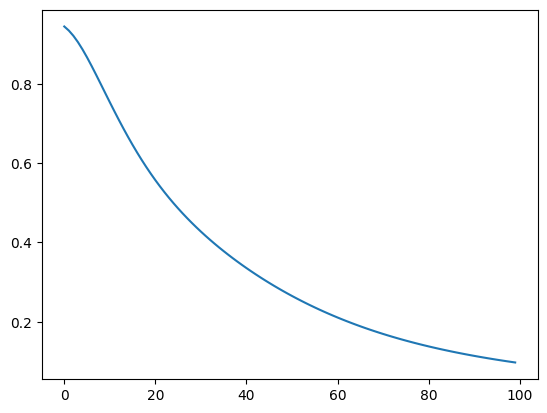

In [113]:
NN.plot_cost()

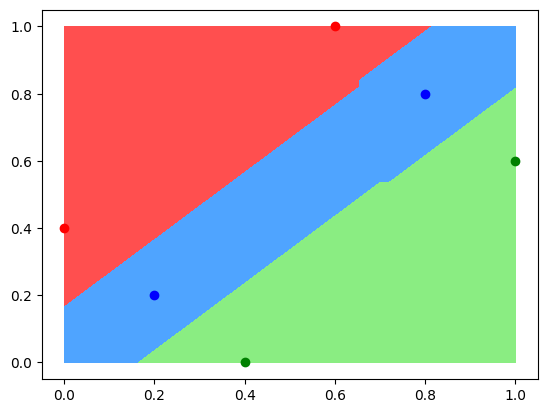

In [114]:
h=0.02
xx, yy = np.meshgrid(np.arange(0, 1.02, h),
                     np.arange(0, 1.02, h))

X_new = np.c_[xx.ravel(), yy.ravel()]
y_pred = np.array([])

for i in range(X_new.shape[0]):
  y_pred = np.append(y_pred, NN.predict(np.array([X_new[i]])))

zz = y_pred.reshape(xx.shape)

custom_cmap = ListedColormap(['#ff4f4f','#4fa4ff','#8aed82'])
plt.contourf(xx, yy, zz, cmap=custom_cmap)

plt.plot(inputs[labels[:]==0,0], inputs[labels[:]==0,1], 'ro')
plt.plot(inputs[labels[:]==1,0], inputs[labels[:]==1,1], 'bo')
plt.plot(inputs[labels[:]==2,0], inputs[labels[:]==2,1], 'go')

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)


plt.show()